In [59]:
from datetime import timedelta
import numpy as np
import holidays
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [4]:
data = pd.read_csv("sales_assortments.csv")

In [6]:
data.sample(5)

,Index,Date,Sales,Assortment
413,413,2017 jan 23,105228.288901,savory_snacks
726,726,2018 feb 05,119996.931836,savory_snacks
1340,1340,2020 apr 06,96502.552184,candy
299,299,2017 apr 27,19545.068384,candy
1403,1403,2020 dec 07,108615.078509,savory_snacks


In [8]:
data.Date = pd.to_datetime(data.Date, format="%Y %b %d")
data.sample(5)

,Index,Date,Sales,Assortment
270,270,2016-09-25,532.777422,drink
555,555,2017-11-15,24946.025244,savory_snacks
1245,1245,2019-11-23,369107.303861,savory_snacks
519,519,2017-05-08,8447.597713,candy
1635,1635,2020-11-25,251869.734005,savory_snacks


In [ ]:
min_year = data["Date"].min().year
max_year = data["Date"].max().year

year_range = range(min_year, max_year + 1)
us_holidays = holidays.US(years=year_range)


def check_next_week_holiday(date):
    for i in range(1, 8):
        if (date + timedelta(days=i)) in us_holidays:
            return 1
    return 0

In [ ]:
data["DayOfWeek"] = data["Date"].dt.dayofweek
data["IsWeekend"] = data["DayOfWeek"].isin([5, 6]).astype(int)
data["Month"] = data["Date"].dt.month
data["IsRealHoliday"] = data["Date"].apply(lambda date: int(date in us_holidays))
data["IsHolidayNextWeek"] = data["Date"].apply(check_next_week_holiday)

In [15]:
data.sample(5)

,Index,Date,Sales,Assortment,DayOfWeek,IsWeekend,Month,IsRealHoliday,IsHolidayNextWeek
1293,1293,2019-10-22,72676.007308,savory_snacks,1,0,10,0,0
789,789,2018-07-10,3290.626301,candy,1,0,7,0,0
545,545,2017-11-07,29221.135232,drink,1,0,11,0,1
686,686,2018-08-24,14743.725447,drink,4,0,8,0,0
257,257,2016-09-12,260.663974,drink,0,0,9,0,0


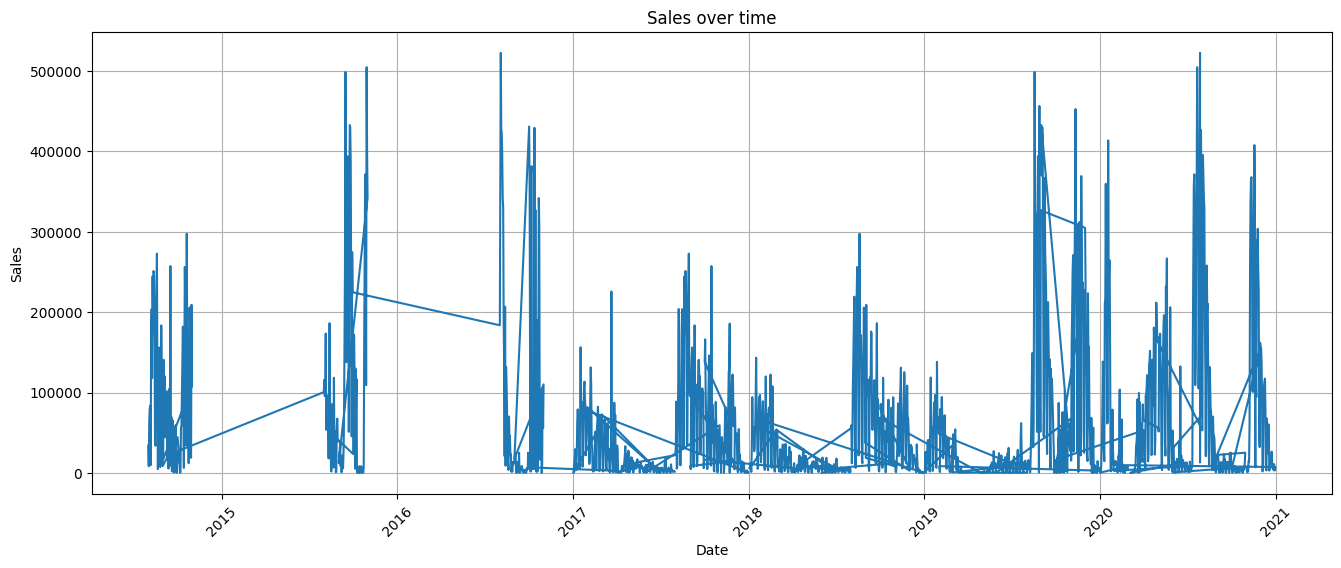

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(data["Date"], data["Sales"], label="Sales")
plt.title("Sales over time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

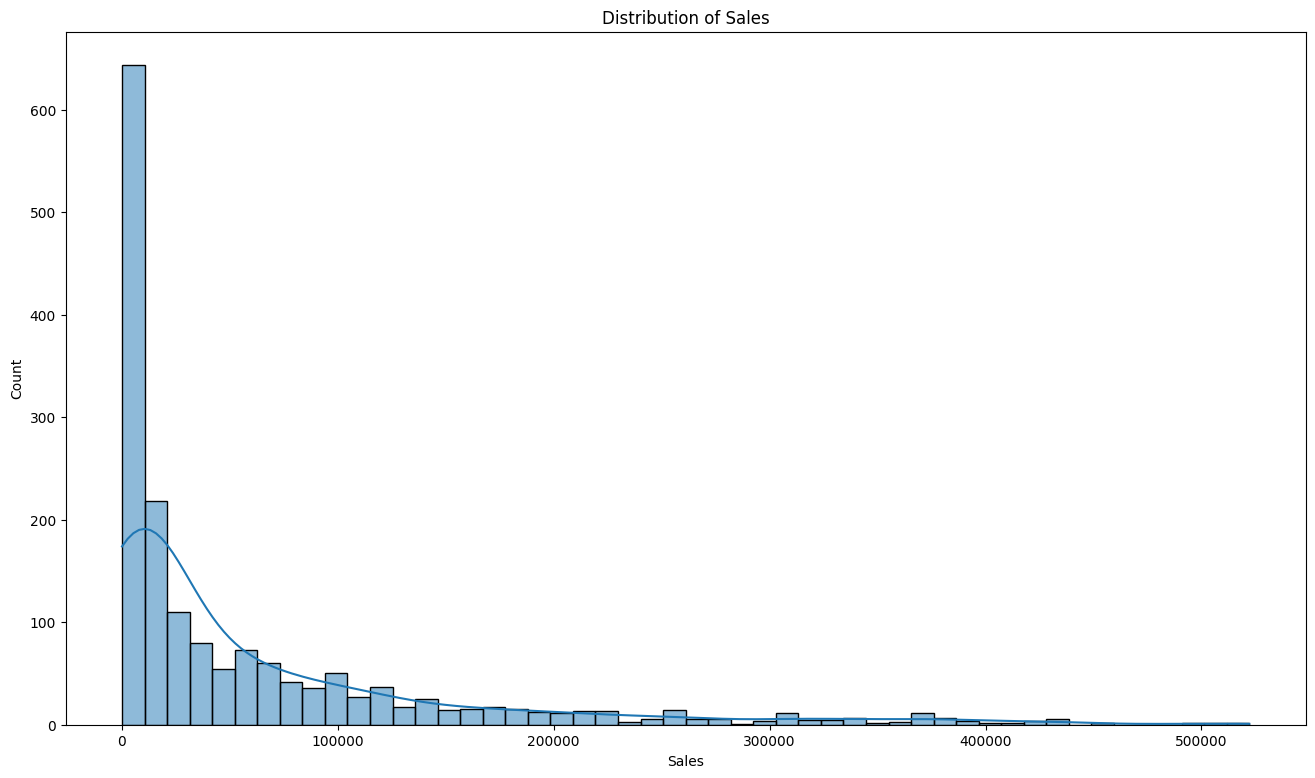

In [ ]:
plt.figure(figsize=(16, 9))
sns.histplot(data["Sales"], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Count")
plt.show()

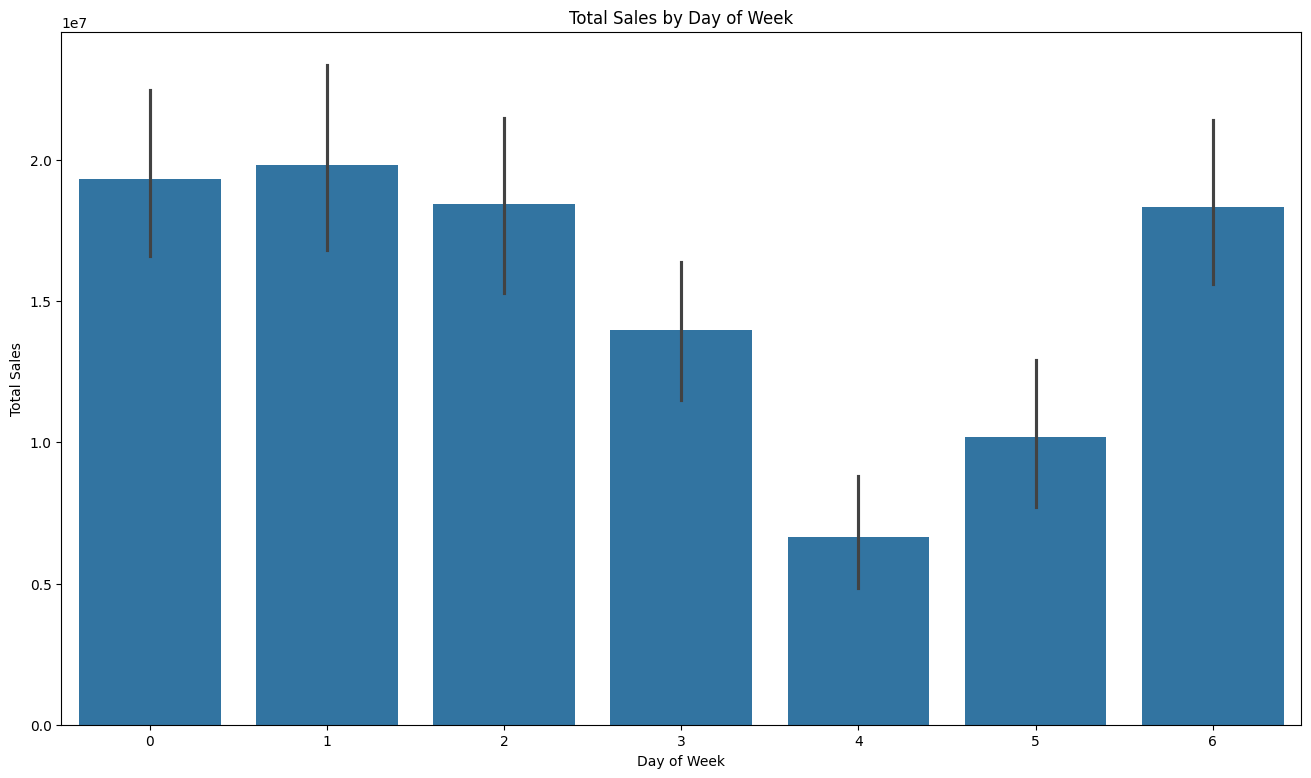

In [ ]:
plt.figure(figsize=(16, 9))
sns.barplot(x="DayOfWeek", y="Sales", data=data, estimator=sum)
plt.title("Total Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Total Sales")
plt.show()

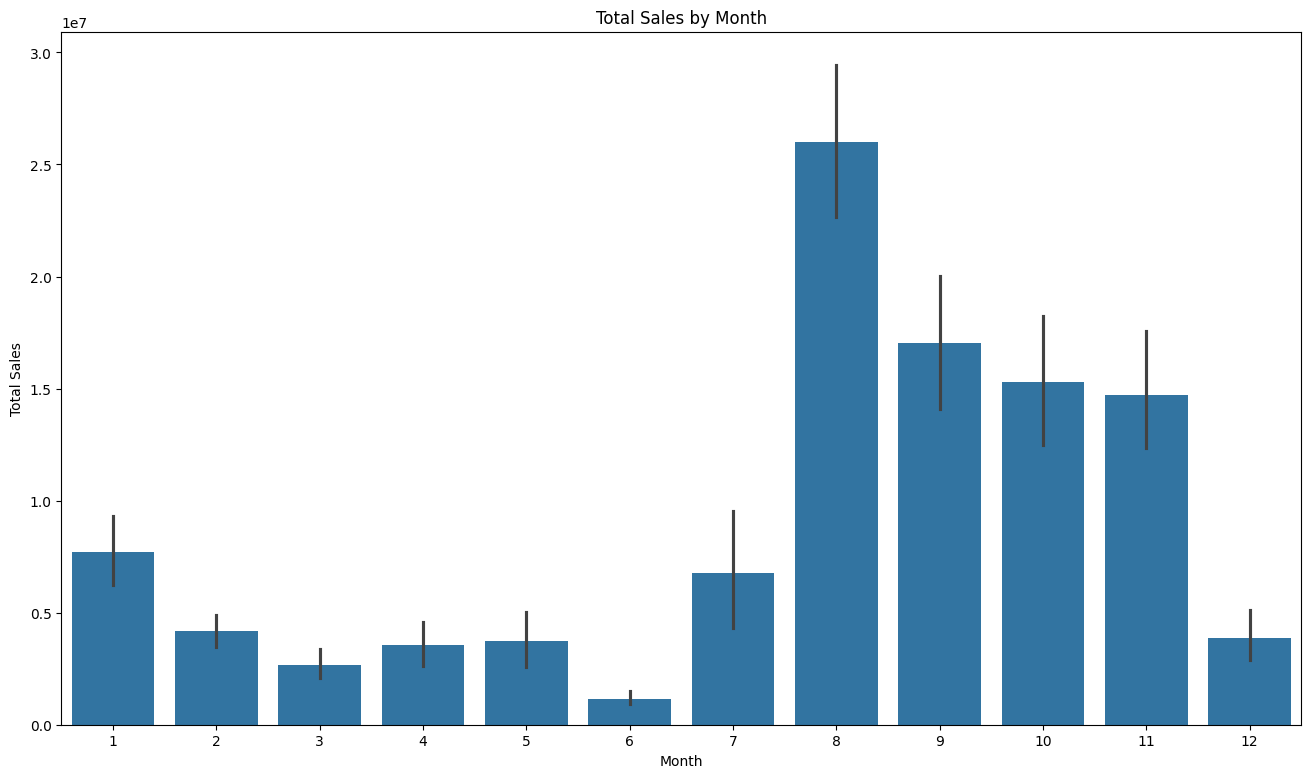

In [ ]:
plt.figure(figsize=(16, 9))
sns.barplot(x="Month", y="Sales", data=data, estimator=sum)
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()

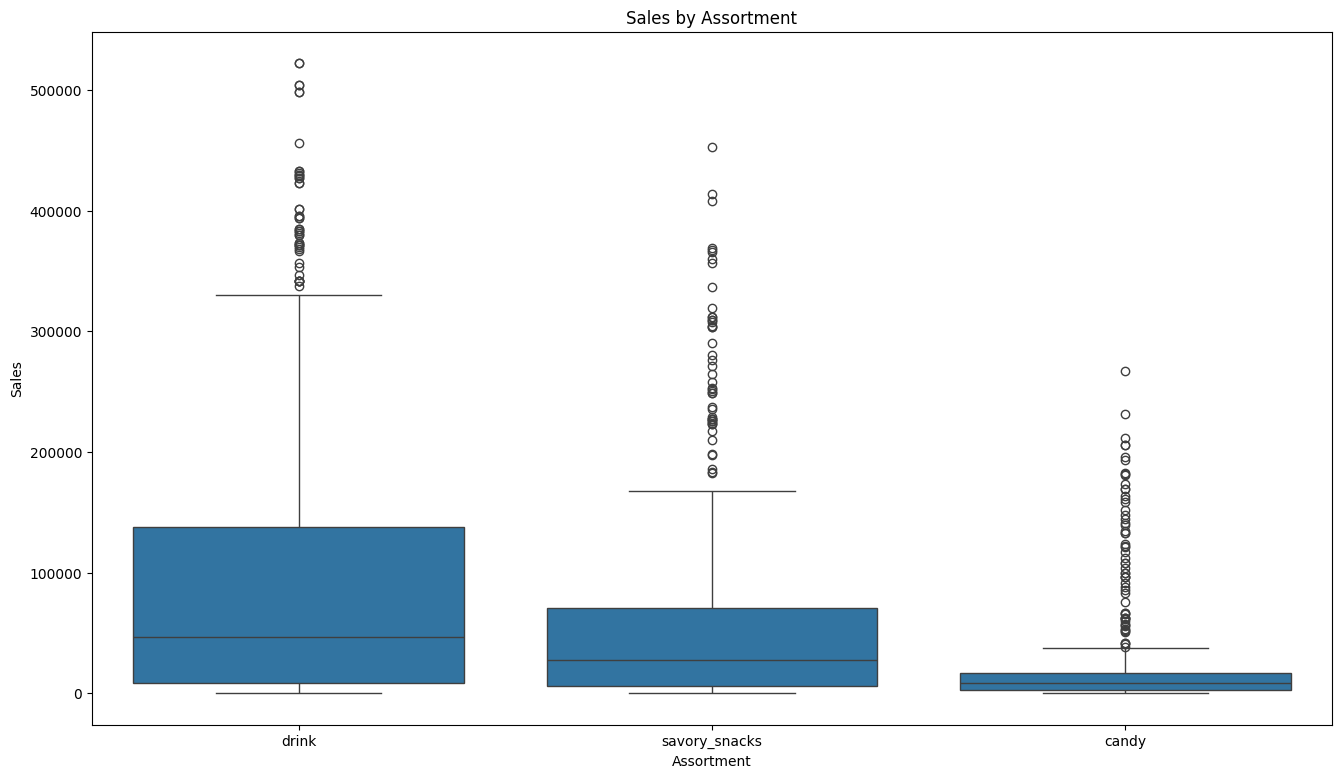

In [ ]:
plt.figure(figsize=(16, 9))
sns.boxplot(x="Assortment", y="Sales", data=data)
plt.title("Sales by Assortment")
plt.xlabel("Assortment")
plt.ylabel("Sales")
plt.show()

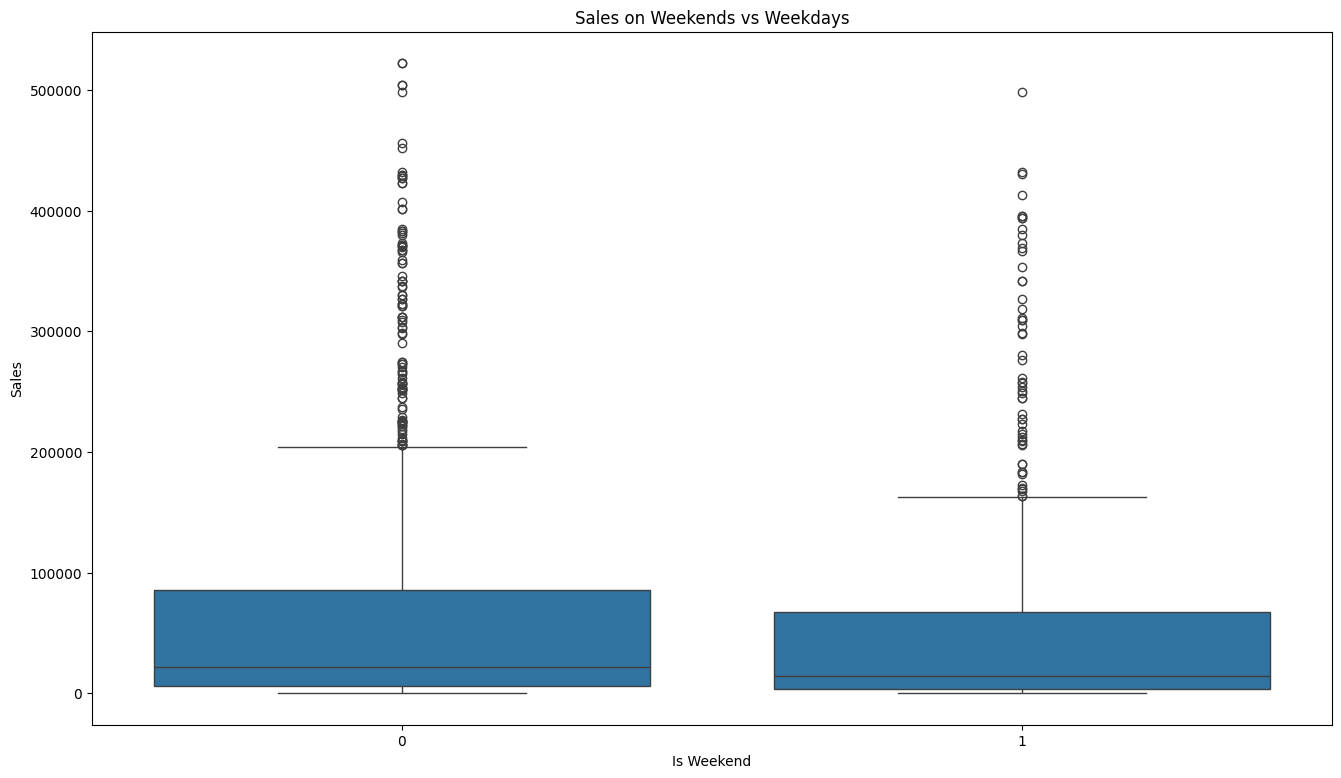

In [ ]:
plt.figure(figsize=(16, 9))
sns.boxplot(x="IsWeekend", y="Sales", data=data)
plt.title("Sales on Weekends vs Weekdays")
plt.xlabel("Is Weekend")
plt.ylabel("Sales")
plt.show()

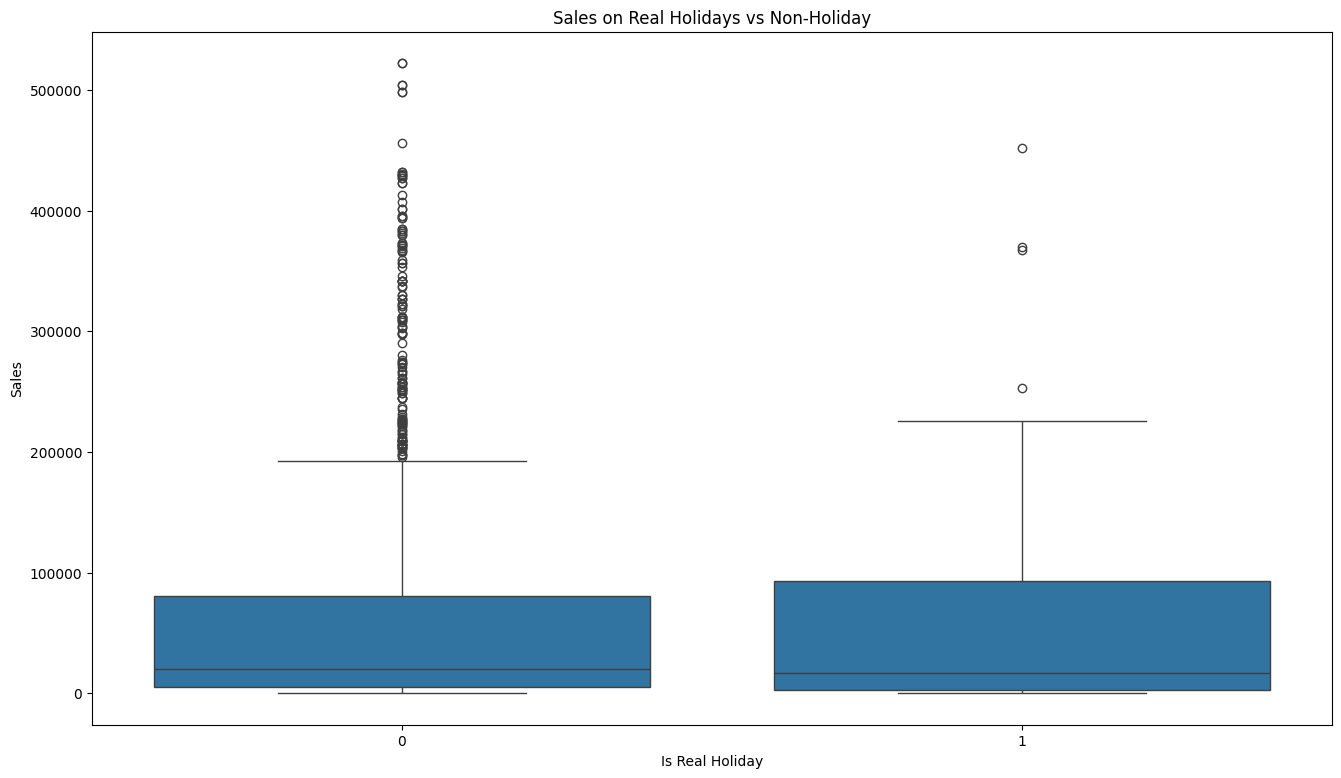

In [ ]:
plt.figure(figsize=(16, 9))
sns.boxplot(x="IsRealHoliday", y="Sales", data=data)
plt.title("Sales on Real Holidays vs Non-Holiday")
plt.xlabel("Is Real Holiday")
plt.ylabel("Sales")
plt.show()

In [30]:
data.columns

Index(['Index', 'Date', 'Sales', 'Assortment', 'DayOfWeek', 'IsWeekend',
       'Month', 'IsRealHoliday', 'IsHolidayNextWeek'],
      dtype='object')

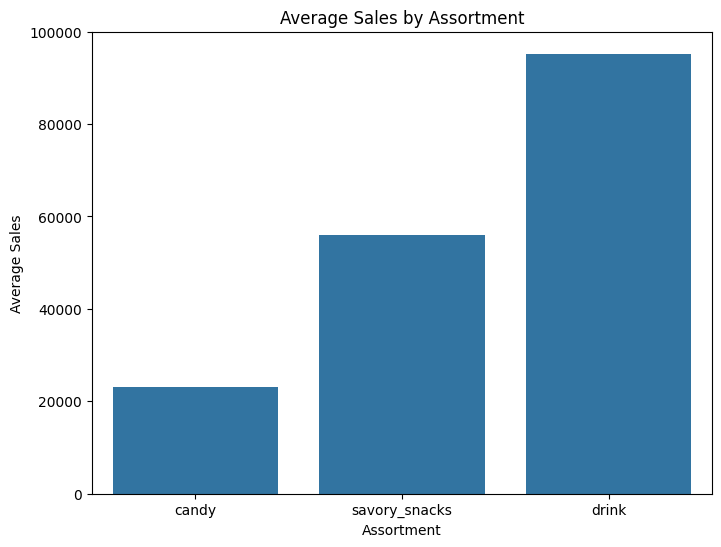

In [ ]:
assortment_mean = data.groupby("Assortment")["Sales"].mean().sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(x=assortment_mean.index, y=assortment_mean.values)
plt.title("Average Sales by Assortment")
plt.ylabel("Average Sales")
plt.xlabel("Assortment")
plt.show()

In [ ]:
features = [
    "Assortment",
    "DayOfWeek",
    "IsWeekend",
    "Month",
    "IsRealHoliday",
    "IsHolidayNextWeek",
]
target = "Sales"

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_cb, X_test_cb, y_train_cb, y_test_cb = (
    X_train.copy(),
    X_test.copy(),
    y_train.copy(),
    y_test.copy(),
)

In [43]:
te = TargetEncoder()
X_train[["Assortment"]] = te.fit_transform(X_train[["Assortment"]], y_train)
X_test[["Assortment"]] = te.transform(X_test[["Assortment"]])

In [ ]:
numeric_cols = ["DayOfWeek", "IsWeekend", "Month", "IsRealHoliday", "IsHolidayNextWeek"]
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

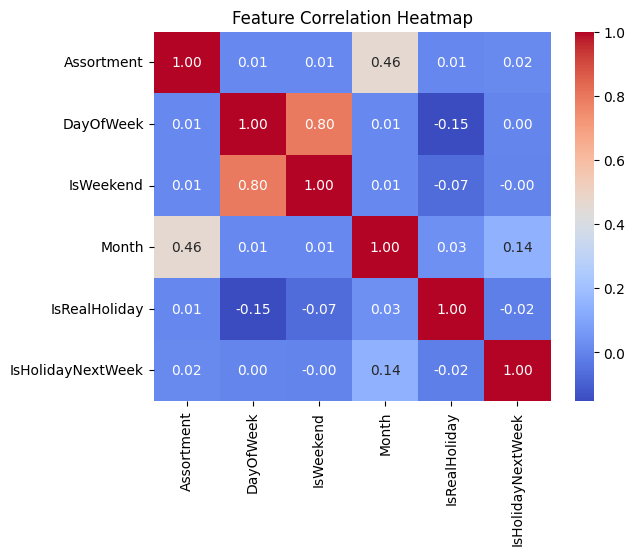

In [45]:
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [49]:
model_cb = CatBoostRegressor(
    iterations=1000,  
    depth=6,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    verbose=100,
)

model_cb.fit(
    X_train_cb, y_train_cb,
    eval_set=(X_test_cb, y_test_cb),
    cat_features=["Assortment"],
    early_stopping_rounds=50
)

Learning rate set to 0.053439
0:	learn: 86561.8284441	test: 111733.2194540	best: 111733.2194540 (0)	total: 4.33ms	remaining: 4.33s
100:	learn: 73756.4935913	test: 107907.2103812	best: 107907.2103812 (100)	total: 62ms	remaining: 552ms
200:	learn: 71400.2999128	test: 105627.6935213	best: 105627.6935213 (200)	total: 96.3ms	remaining: 383ms
300:	learn: 69790.5163324	test: 105362.7016653	best: 105362.7016653 (300)	total: 130ms	remaining: 302ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 105362.7017
bestIteration = 300

Shrink model to first 301 iterations.


In [50]:
y_pred_cb = model_cb.predict(X_test_cb)

# --- Метрики ---
rmse_cb = np.sqrt(mean_squared_error(y_test_cb, y_pred_cb))
r2_cb = r2_score(y_test_cb, y_pred_cb)

print(f"CatBoost RMSE: {rmse_cb:.4f}")
print(f"CatBoost R²: {r2_cb:.4f}")

CatBoost RMSE: 105362.7016
CatBoost R²: 0.0876


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
def train_model(
    model,
    train_loader,
    val_loader,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
):
    best_model_wts = model.state_dict()
    best_rmse = float("inf")

    losses = {"train": [], "val": []}
    metrics = {"train": {"RMSE": [], "R2": []}, "val": {"RMSE": [], "R2": []}}

    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            all_labels = []
            all_preds = []

            for inputs, labels in tqdm.tqdm(loader, leave=False, desc=f"{phase} iter:"):
                inputs, labels = inputs.to(device), labels.to(device)

                if phase == "train":
                    optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_labels.append(labels.detach().cpu().numpy())
                all_preds.append(outputs.detach().cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            y_true = np.vstack(all_labels)
            y_pred = np.vstack(all_preds)
            epoch_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            epoch_r2 = r2_score(y_true, y_pred)

            losses[phase].append(epoch_loss)
            metrics[phase]["RMSE"].append(epoch_rmse)
            metrics[phase]["R2"].append(epoch_r2)

            tqdm.tqdm.write(
                f"{phase} Epoch {epoch + 1}/{num_epochs} "
                f"Loss: {epoch_loss:.4f} RMSE: {epoch_rmse:.4f} R2: {epoch_r2:.4f}"
            )

            # сохраняем лучшую модель по RMSE на валидации
            if phase == "val" and epoch_rmse < best_rmse:
                best_rmse = epoch_rmse
                best_model_wts = model.state_dict()

        # шаг scheduler по RMSE на валидации
        scheduler.step(epoch_rmse)

    print(f"Best val RMSE: {best_rmse:.4f}")
    model.load_state_dict(best_model_wts)
    return model, (losses, metrics)


In [57]:
def plot_grafs(metrics):
    losses, metric_vals = metrics

    plt.figure(figsize=(16, 6))
    plt.plot(losses["train"], label="Train Loss")
    plt.plot(losses["val"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(16, 6))
    plt.plot(metric_vals["train"]["RMSE"], label="Train RMSE")
    plt.plot(metric_vals["val"]["RMSE"], label="Validation RMSE")
    plt.title("Training and Validation RMSE")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

    plt.figure(figsize=(16, 6))
    plt.plot(metric_vals["train"]["R2"], label="Train R2")
    plt.plot(metric_vals["val"]["R2"], label="Validation R2")
    plt.title("Training and Validation R2 Score")
    plt.xlabel("Epochs")
    plt.ylabel("R2")
    plt.legend()
    plt.show()


In [58]:
class Model(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)  # выходной слой для регрессии
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [60]:
batch_size = 64

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}

In [62]:
model = Model(input_dim=X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

In [63]:
model_trained, metrics = train_model(
    model,
    train_loader,
    val_loader,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=50,
)

train Epoch 1/50 Loss: 10258800176.1882 RMSE: 101285.7376 R2: -0.3410


val Epoch 1/50 Loss: 15204768171.6706 RMSE: 123307.6185 R2: -0.2497


train Epoch 2/50 Loss: 7297627810.6353 RMSE: 85426.1532 R2: 0.0461


val Epoch 2/50 Loss: 12897549348.1412 RMSE: 113567.3779 R2: -0.0600


train Epoch 3/50 Loss: 6766291998.1176 RMSE: 82257.4705 R2: 0.1155


val Epoch 3/50 Loss: 13090082912.3765 RMSE: 114411.9043 R2: -0.0758


train Epoch 4/50 Loss: 6848491056.1882 RMSE: 82755.6101 R2: 0.1048


val Epoch 4/50 Loss: 13019682424.4706 RMSE: 114103.8247 R2: -0.0701


train Epoch 5/50 Loss: 6684648345.6000 RMSE: 81759.7025 R2: 0.1262


val Epoch 5/50 Loss: 13063653225.4118 RMSE: 114296.3312 R2: -0.0737


train Epoch 6/50 Loss: 6810008647.5294 RMSE: 82522.7792 R2: 0.1098


val Epoch 6/50 Loss: 13003572946.8235 RMSE: 114033.2112 R2: -0.0687


train Epoch 7/50 Loss: 6665110130.4471 RMSE: 81640.1250 R2: 0.1288


val Epoch 7/50 Loss: 13050418206.1176 RMSE: 114238.4269 R2: -0.0726


train Epoch 8/50 Loss: 6655873487.8118 RMSE: 81583.5340 R2: 0.1300


val Epoch 8/50 Loss: 13070780584.6588 RMSE: 114327.5138 R2: -0.0743


train Epoch 9/50 Loss: 6721222180.1412 RMSE: 81983.0632 R2: 0.1214


val Epoch 9/50 Loss: 12981459058.4471 RMSE: 113936.2101 R2: -0.0669


train Epoch 10/50 Loss: 6649084548.5176 RMSE: 81541.9182 R2: 0.1309


val Epoch 10/50 Loss: 13031729790.4941 RMSE: 114156.6037 R2: -0.0711


train Epoch 11/50 Loss: 6653354483.9529 RMSE: 81568.0973 R2: 0.1303


val Epoch 11/50 Loss: 13020807746.2588 RMSE: 114108.7470 R2: -0.0702


train Epoch 12/50 Loss: 6596979001.2235 RMSE: 81221.7902 R2: 0.1377


val Epoch 12/50 Loss: 12991977935.8118 RMSE: 113982.3515 R2: -0.0678


train Epoch 13/50 Loss: 6755179056.1882 RMSE: 82189.8929 R2: 0.1170


val Epoch 13/50 Loss: 13015085248.7529 RMSE: 114083.6802 R2: -0.0697


train Epoch 14/50 Loss: 6850740585.4118 RMSE: 82769.1985 R2: 0.1045


val Epoch 14/50 Loss: 13038605811.9529 RMSE: 114186.7170 R2: -0.0716


train Epoch 15/50 Loss: 6792389936.1882 RMSE: 82415.9581 R2: 0.1121


val Epoch 15/50 Loss: 13012739728.5647 RMSE: 114073.3934 R2: -0.0695


train Epoch 16/50 Loss: 6704872038.4000 RMSE: 81883.2855 R2: 0.1236


val Epoch 16/50 Loss: 13038728047.4353 RMSE: 114187.2506 R2: -0.0716


train Epoch 17/50 Loss: 6724524947.5765 RMSE: 82003.2015 R2: 0.1210


val Epoch 17/50 Loss: 12984858352.9412 RMSE: 113951.1238 R2: -0.0672


train Epoch 18/50 Loss: 6667201481.7882 RMSE: 81652.9303 R2: 0.1285


val Epoch 18/50 Loss: 13017155168.3765 RMSE: 114092.7499 R2: -0.0699


train Epoch 19/50 Loss: 6678474098.4471 RMSE: 81721.9293 R2: 0.1270


val Epoch 19/50 Loss: 12999438625.1294 RMSE: 114015.0749 R2: -0.0684


train Epoch 20/50 Loss: 6730066895.8118 RMSE: 82036.9852 R2: 0.1203


val Epoch 20/50 Loss: 12980477132.8000 RMSE: 113931.8960 R2: -0.0668


train Epoch 21/50 Loss: 6645093829.2706 RMSE: 81517.4484 R2: 0.1314


val Epoch 21/50 Loss: 12991308583.1529 RMSE: 113979.4227 R2: -0.0677


train Epoch 22/50 Loss: 6659576880.1882 RMSE: 81606.2335 R2: 0.1295


val Epoch 22/50 Loss: 12990351829.8353 RMSE: 113975.2226 R2: -0.0677


train Epoch 23/50 Loss: 6715890182.0235 RMSE: 81950.5349 R2: 0.1221


val Epoch 23/50 Loss: 13001329374.8706 RMSE: 114023.3778 R2: -0.0686


train Epoch 24/50 Loss: 6537907056.9412 RMSE: 80857.3230 R2: 0.1454


val Epoch 24/50 Loss: 12988600307.9529 RMSE: 113967.5406 R2: -0.0675


train Epoch 25/50 Loss: 6762307138.2588 RMSE: 82233.2449 R2: 0.1161


val Epoch 25/50 Loss: 13004354325.0824 RMSE: 114036.6324 R2: -0.0688


train Epoch 26/50 Loss: 6802808832.0000 RMSE: 82479.1449 R2: 0.1108


val Epoch 26/50 Loss: 13007065943.3412 RMSE: 114048.5297 R2: -0.0690


train Epoch 27/50 Loss: 6676693922.6353 RMSE: 81711.0366 R2: 0.1273


val Epoch 27/50 Loss: 13016168899.7647 RMSE: 114088.4238 R2: -0.0698


train Epoch 28/50 Loss: 6821398943.6235 RMSE: 82591.7582 R2: 0.1083


val Epoch 28/50 Loss: 13018909262.3059 RMSE: 114100.4369 R2: -0.0700


train Epoch 29/50 Loss: 6715039575.3412 RMSE: 81945.3430 R2: 0.1222


val Epoch 29/50 Loss: 13016549394.0706 RMSE: 114090.0977 R2: -0.0698


train Epoch 30/50 Loss: 6687332936.2824 RMSE: 81776.1174 R2: 0.1259


val Epoch 30/50 Loss: 13009057575.1529 RMSE: 114057.2521 R2: -0.0692


train Epoch 31/50 Loss: 6739194753.5059 RMSE: 82092.5994 R2: 0.1191


val Epoch 31/50 Loss: 13019128133.2706 RMSE: 114101.3972 R2: -0.0700


train Epoch 32/50 Loss: 6630963091.5765 RMSE: 81430.7264 R2: 0.1332


val Epoch 32/50 Loss: 12991778081.1294 RMSE: 113981.4890 R2: -0.0678


train Epoch 33/50 Loss: 6670675660.8000 RMSE: 81674.2000 R2: 0.1280


val Epoch 33/50 Loss: 12992022732.8000 RMSE: 113982.5581 R2: -0.0678


train Epoch 34/50 Loss: 6756034114.2588 RMSE: 82195.0944 R2: 0.1169


val Epoch 34/50 Loss: 12994073865.0353 RMSE: 113991.5506 R2: -0.0680


train Epoch 35/50 Loss: 6614954396.6118 RMSE: 81332.3674 R2: 0.1353


val Epoch 35/50 Loss: 12989094147.0118 RMSE: 113969.7105 R2: -0.0675


train Epoch 36/50 Loss: 6715554394.3529 RMSE: 81948.4888 R2: 0.1222


val Epoch 36/50 Loss: 12991148453.6471 RMSE: 113978.7264 R2: -0.0677


train Epoch 37/50 Loss: 6738019891.2000 RMSE: 82085.4423 R2: 0.1192


val Epoch 37/50 Loss: 12993012717.9294 RMSE: 113986.8927 R2: -0.0679


train Epoch 38/50 Loss: 6690567107.7647 RMSE: 81795.8872 R2: 0.1254


val Epoch 38/50 Loss: 12996276187.8588 RMSE: 114001.2115 R2: -0.0681


train Epoch 39/50 Loss: 6717447077.6471 RMSE: 81960.0340 R2: 0.1219


val Epoch 39/50 Loss: 12996259846.0235 RMSE: 114001.1441 R2: -0.0681


train Epoch 40/50 Loss: 6697760156.6118 RMSE: 81839.8483 R2: 0.1245


val Epoch 40/50 Loss: 12996270104.0941 RMSE: 114001.1846 R2: -0.0681


train Epoch 41/50 Loss: 6697042185.0353 RMSE: 81835.4564 R2: 0.1246


val Epoch 41/50 Loss: 12996398134.2118 RMSE: 114001.7504 R2: -0.0681


train Epoch 42/50 Loss: 6653040519.5294 RMSE: 81566.1734 R2: 0.1303


val Epoch 42/50 Loss: 12996292891.1059 RMSE: 114001.2834 R2: -0.0681


train Epoch 43/50 Loss: 6777016937.4118 RMSE: 82322.6386 R2: 0.1141


val Epoch 43/50 Loss: 12994146340.1412 RMSE: 113991.8695 R2: -0.0680


train Epoch 44/50 Loss: 6669233139.9529 RMSE: 81665.3730 R2: 0.1282


val Epoch 44/50 Loss: 12996694871.3412 RMSE: 114003.0439 R2: -0.0682


train Epoch 45/50 Loss: 6775282389.8353 RMSE: 82312.1022 R2: 0.1144


val Epoch 45/50 Loss: 12997516721.6941 RMSE: 114006.6547 R2: -0.0682


train Epoch 46/50 Loss: 6756035861.0824 RMSE: 82195.1037 R2: 0.1169


val Epoch 46/50 Loss: 12999229102.6824 RMSE: 114014.1633 R2: -0.0684


train Epoch 47/50 Loss: 6625525248.0000 RMSE: 81397.3295 R2: 0.1339


val Epoch 47/50 Loss: 12998383013.6471 RMSE: 114010.4495 R2: -0.0683


train Epoch 48/50 Loss: 6747323024.5647 RMSE: 82142.0896 R2: 0.1180


val Epoch 48/50 Loss: 13000903740.2353 RMSE: 114021.5143 R2: -0.0685


train Epoch 49/50 Loss: 6757857569.1294 RMSE: 82206.1907 R2: 0.1166


val Epoch 49/50 Loss: 13002003582.4941 RMSE: 114026.3279 R2: -0.0686


train Epoch 50/50 Loss: 6749973534.1176 RMSE: 82158.2224 R2: 0.1177


val Epoch 50/50 Loss: 13001860812.8000 RMSE: 114025.7038 R2: -0.0686
Best val RMSE: 113567.3779


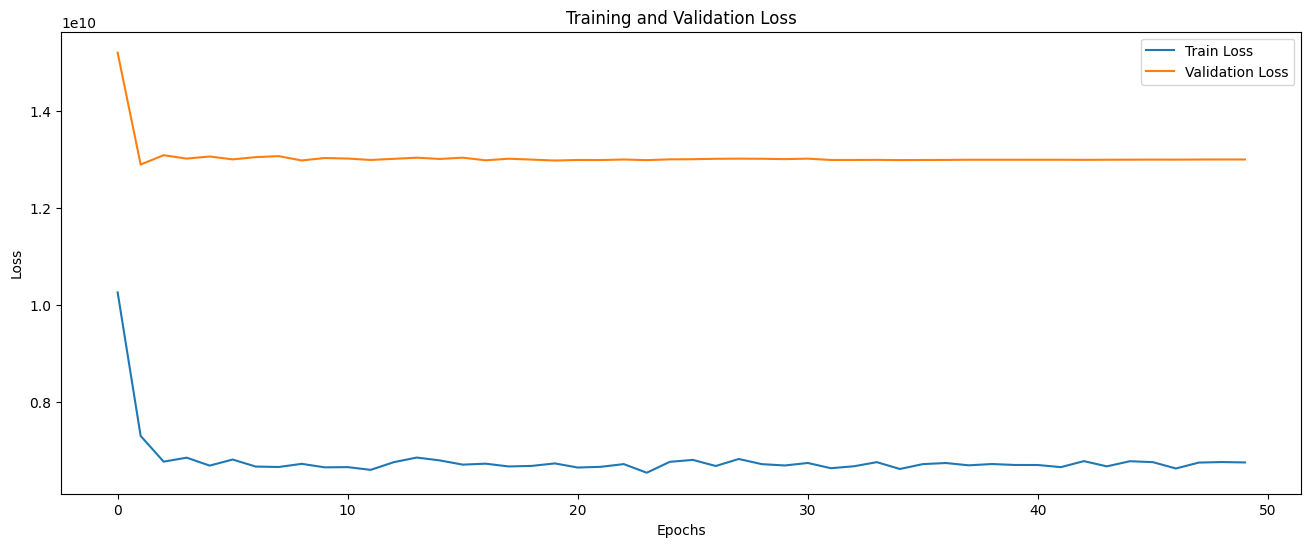

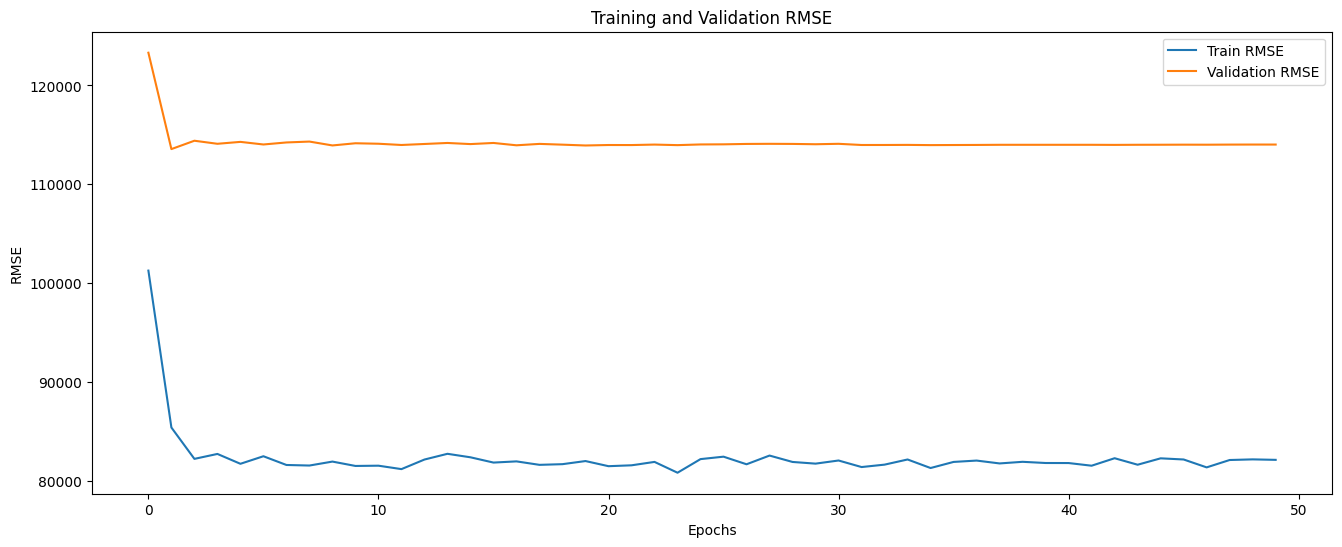

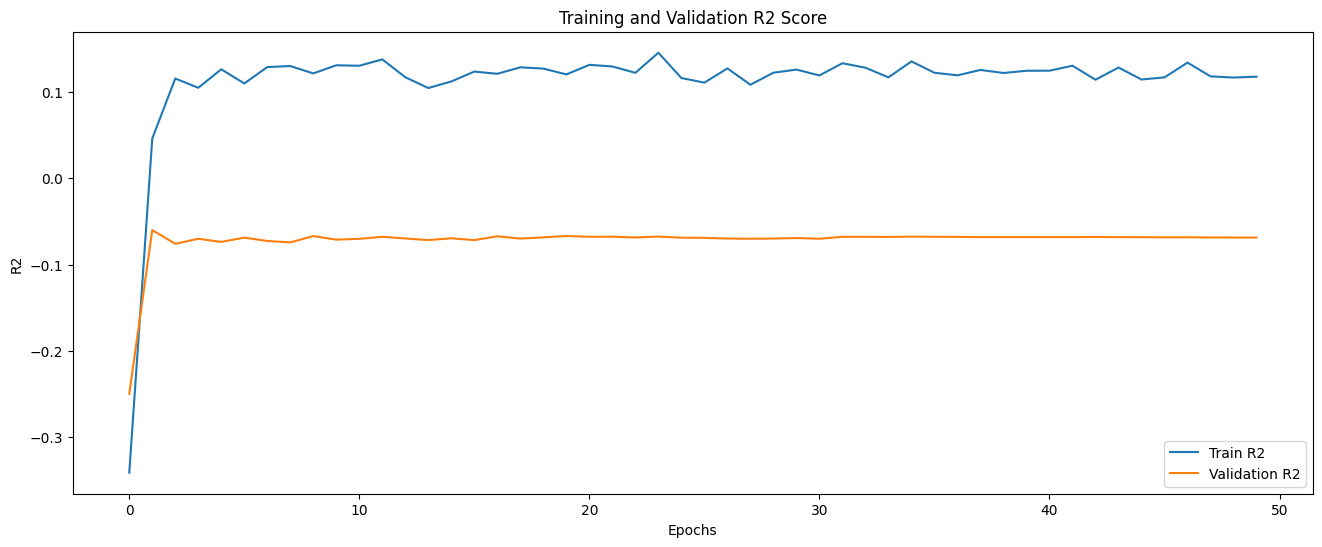

In [64]:
plot_grafs(metrics)